Define variables for computation

In [1]:
# What company to look up, symbol and lower case name
SYMBOL="BKNG" # e.g. "TSLA"
KEYWORD="Booking holdings" # e.g. "tesla"

# What timeframe to lookup as a tuple e.g. (2023, 10, 29)
# if undefined, then it looks up the last month
START_DATE = (2022, 10, 29)
END_DATE = (2023, 10, 29)

Import packages

In [14]:
# %load_ext autoreload
# %autoreload 2

import importlib
import yfinance as yf
from transformers import pipeline
from datetime import datetime
import scraper
import pandas

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Scrape the news from gnews. This takes a while...

(see implementation in scraper.py)

In [5]:
importlib.reload(scraper)

articles = scraper.get_articles(KEYWORD, START_DATE, END_DATE)

articles

Getting articles...
Start querying GNews


{datetime.datetime(2023, 10, 31, 0, 0): ['We use cookies and data to\n\nDeliver and maintain Google services\n\nTrack outages and protect against spam, fraud, and abuse\n\nMeasure audience engagement and site statistics to understand how our services are used and enhance the quality of those services\n\nIf you choose to “Accept all,” we will also use cookies and data to\n\nDevelop and improve new services\n\nDeliver and measure the effectiveness of ads\n\nShow personalized content, depending on your settings\n\nShow personalized ads, depending on your settings\n\nIf you choose to “Reject all,” we will not use cookies for these additional purposes.\n\nNon-personalized content is influenced by things like the content you’re currently viewing, activity in your active Search session, and your location. Non-personalized ads are influenced by the content you’re currently viewing and your general location. Personalized content and ads can also include more relevant results, recommendations, a

Now fetch stock data

In [6]:
tsla = yf.Ticker(SYMBOL)

sd = datetime(START_DATE[0], START_DATE[1], START_DATE[2])
ed = datetime(END_DATE[0], END_DATE[1], END_DATE[2])

price_history = tsla.history(start=sd, end=ed)

print(price_history)

                                  Open         High          Low        Close  \
Date                                                                            
2022-10-31 00:00:00-04:00  1870.910034  1885.339966  1837.839966  1869.479980   
2022-11-01 00:00:00-04:00  1891.250000  1927.000000  1886.040039  1889.520020   
2022-11-02 00:00:00-04:00  1862.790039  1884.729980  1771.319946  1778.180054   
2022-11-03 00:00:00-04:00  1849.000000  1902.699951  1822.760010  1825.729980   
2022-11-04 00:00:00-04:00  1884.829956  1916.150024  1852.099976  1874.400024   
...                                ...          ...          ...          ...   
2023-10-23 00:00:00-04:00  2753.760010  2841.459961  2742.000000  2819.540039   
2023-10-24 00:00:00-04:00  2836.949951  2858.899902  2817.239990  2835.370117   
2023-10-25 00:00:00-04:00  2822.620117  2851.520020  2806.870117  2812.919922   
2023-10-26 00:00:00-04:00  2795.550049  2818.719971  2733.040039  2742.689941   
2023-10-27 00:00:00-04:00  2

Now, we can process this and get the sentiment for all articles

In [7]:
sentiment_per_day = {}

# Go through the articles per day
for date in articles:
  group = articles[date]
  
  score = 0
  
  for article in group:
    # Get the first 512 characters, the model cant handle more.
    sc = sentiment_pipeline(article[:512])[0]
    if sc['label'] == 'POSITIVE':
      score += sc['score']
    else:
      score -= sc['score']
      
  sentiment_per_day[date] = score
      
sentiment_per_day

{datetime.datetime(2023, 10, 31, 0, 0): 3.569725811481476,
 datetime.datetime(2023, 10, 30, 0, 0): 5.099608302116394,
 datetime.datetime(2023, 10, 20, 0, 0): 1.0199216604232788,
 datetime.datetime(2023, 10, 11, 0, 0): 0.5099608302116394,
 datetime.datetime(2023, 10, 3, 0, 0): 1.0199216604232788,
 datetime.datetime(2023, 10, 10, 0, 0): 1.0199216604232788,
 datetime.datetime(2023, 10, 5, 0, 0): 0.5099608302116394,
 datetime.datetime(2023, 10, 24, 0, 0): 1.5298824906349182,
 datetime.datetime(2023, 10, 23, 0, 0): 0.5099608302116394,
 datetime.datetime(2023, 10, 6, 0, 0): 1.5298824906349182,
 datetime.datetime(2023, 10, 29, 0, 0): 2.0398433208465576,
 datetime.datetime(2023, 10, 22, 0, 0): 0.5099608302116394,
 datetime.datetime(2023, 10, 25, 0, 0): 2.0398433208465576,
 datetime.datetime(2023, 10, 12, 0, 0): 0.5099608302116394,
 datetime.datetime(2023, 10, 16, 0, 0): 0.5099608302116394,
 datetime.datetime(2023, 10, 27, 0, 0): 1.5298824906349182,
 datetime.datetime(2023, 10, 4, 0, 0): 0.5099

Now link the price history and news-sentiment together

         date  sentiment  color  \
0  2023-01-11   0.509961  green   
1  2023-02-23   0.509961  green   
2  2023-03-01   0.509961  green   
3  2023-03-21   0.509961  green   
4  2023-03-22   0.509961  green   
5  2023-04-21   0.509961  green   
6  2023-05-01   0.509961  green   
7  2023-05-03   0.509961  green   
8  2023-05-04   0.509961  green   
9  2023-05-08   0.509961  green   
10 2023-05-25   1.019922  green   
11 2023-06-07   0.509961  green   
12 2023-06-09   1.019922  green   
13 2023-06-14   0.509961  green   
14 2023-06-16   0.509961  green   
15 2023-06-22   0.509961  green   
16 2023-06-26   0.509961  green   
17 2023-06-27   0.509961  green   
18 2023-06-28   0.509961  green   
19 2023-07-05   1.019922  green   
20 2023-07-10   0.509961  green   
21 2023-07-19   0.509961  green   
22 2023-08-02   0.509961  green   
23 2023-08-03   0.509961  green   
24 2023-08-04   1.019922  green   
25 2023-08-07   1.019922  green   
26 2023-08-08   0.509961  green   
27 2023-08-10   0.50

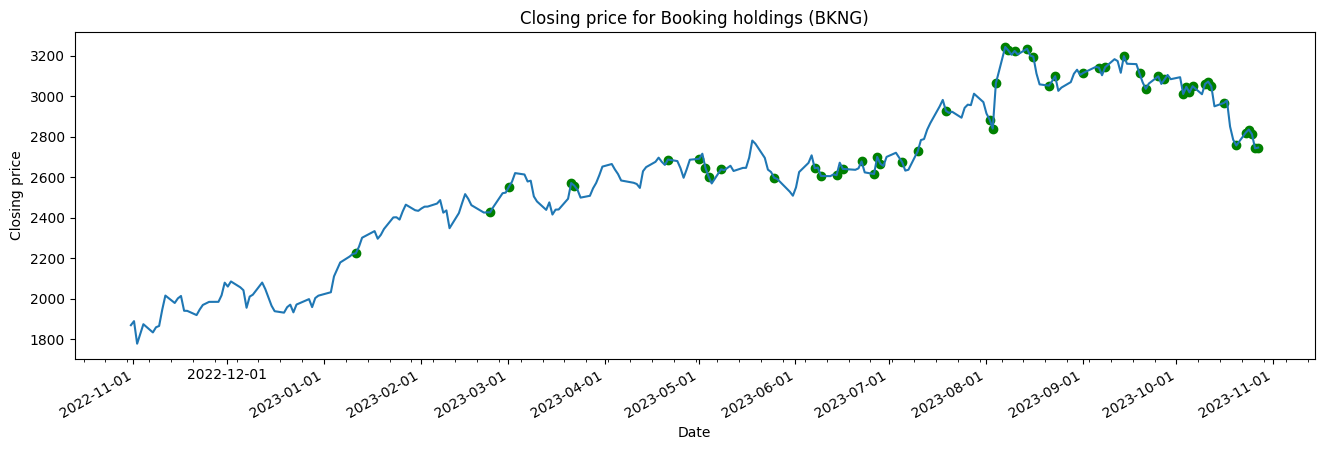

In [27]:
closing = price_history.get('Close')

fig, ax = plt.subplots()

fig.set_figwidth(16)

x = closing.index.to_pydatetime()
y = closing

ax.set_title(f'Closing price for {KEYWORD} ({SYMBOL})')

ax.set_xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

ax.set_ylabel('Closing price')


arr = {'date': [], 'sentiment': [], 'color': [], 'articles': []}

for date in x:
  price = closing[date]
  
  d = datetime(date.year, date.month, date.day)
  
  sentiment = sentiment_per_day.get(d)
  article = articles.get(d)
  
  color = 'green' if sentiment and sentiment > 0 else 'red'
  
  if sentiment:
    arr['date'].append(d)
    arr['sentiment'].append(sentiment)
    arr['color'].append(color)
    arr['articles'].append(article[0])
  
  if sentiment != None:
    ax.scatter(date, price, color=color)

pandas.set_option('display.max_colwidth', None)
pandas.set_option('display.width', 2000)
print(pandas.DataFrame(arr))

ax.plot(x, y);